In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from lane_lines.filter import filter
from lane_lines.PerspectiveTransformer import ImageDistorter
from lane_lines.PerspectiveTransformer import RoadTransformer

distorter = ImageDistorter()
transformer = RoadTransformer()

image = mpimg.imread('test_images/test2.jpg')
shape = image.shape[0:2]
undistorted = distorter.undistort(image)
warped = transformer.warped(undistorted)
filtered = filter(warped)



Unable to find corners in image /Users/kyledorman/Documents/carnd/Advanced-Lane-Lines/camera_cal/calibration1.jpg.
Unable to find corners in image /Users/kyledorman/Documents/carnd/Advanced-Lane-Lines/camera_cal/calibration4.jpg.
Unable to find corners in image /Users/kyledorman/Documents/carnd/Advanced-Lane-Lines/camera_cal/calibration5.jpg.


In [18]:
filtered.shape

(500, 400)

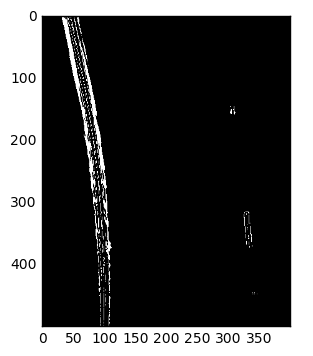

In [2]:
plt.imshow(filtered, cmap='gray')
plt.show()

/Users/kyledorman/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


([(97, 500), (97, 450), (98, 400), (94, 350), (91, 300), (85, 250), (78, 200), (69, 150), (58, 100), (47, 50)], [(325, 400), (322, 350), (298, 200)])


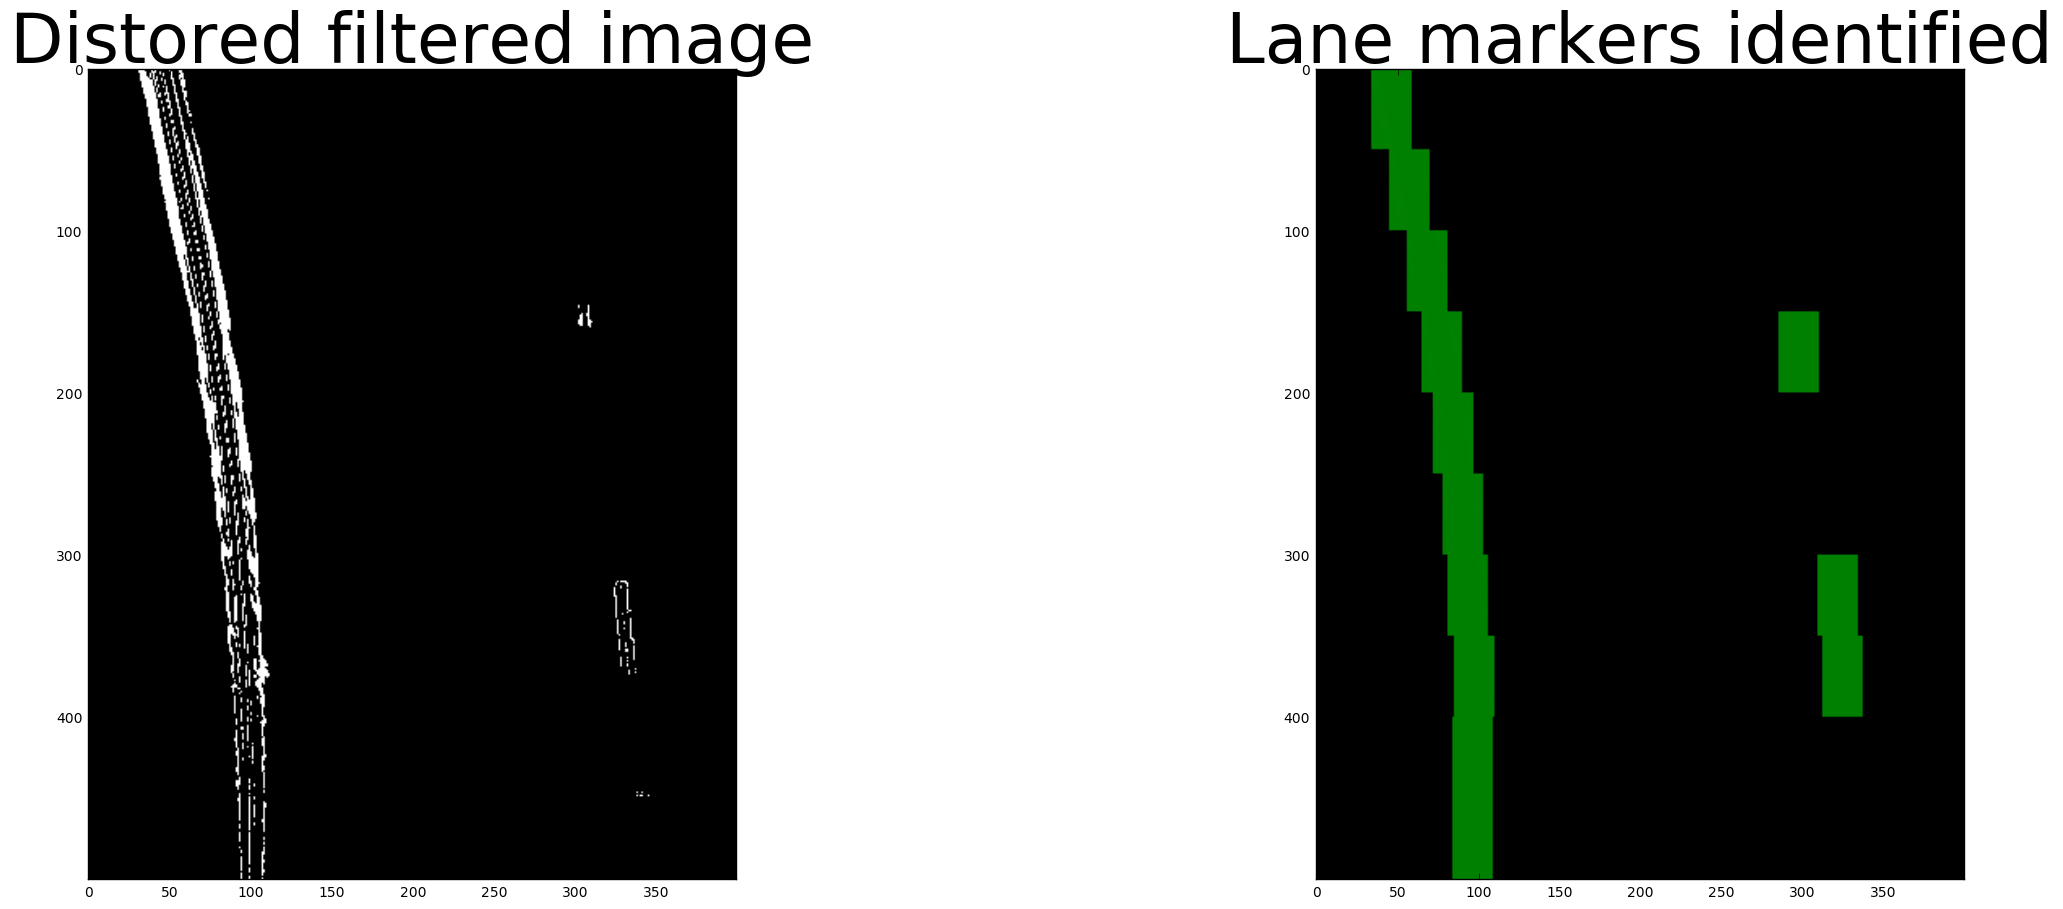

In [3]:
window_width = 25 
window_height = 50 # Break image into 10 vertical layers since image height is 500
margin = 50 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center, mask_y):  
  v_start = int(mask_y - height)
  v_end = int(mask_y)
  h_start = max(0,int(center-width/2))
  h_end = min(int(center+width/2),img_ref.shape[1])

  output = np.zeros_like(img_ref)
  output[v_start:v_end,h_start:h_end] = 1
  return output

def initial_centers(image):
  histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
  midpoint = np.int(histogram.shape[0]/2)
  leftx_base = np.argmax(histogram[:midpoint])
  rightx_base = np.argmax(histogram[midpoint:]) + midpoint
  return (leftx_base, rightx_base)

def find_window_centroids(image, window_width, window_height, margin):  
  left_center, right_center = initial_centers(image)
  left_centroids = find_lane_centroids(image, left_center, window_width, window_height, margin)
  right_centroids = find_lane_centroids(image, right_center, window_width, window_height, margin)
    
  return (left_centroids, right_centroids)

def find_lane_centroids(image, center, window_width, window_height, margin):
  centroids = []

  for level in range(int(image.shape[0]/window_height)):
    height = int(image.shape[0]-(level*window_height))
    found_centroid = find_window_centroid(image, window_width, window_height, margin, center, height)
    
    if found_centroid is not None:
      center = found_centroid
      centroids.append((found_centroid, height))
    
  return centroids
  
  
def find_window_centroid(image, window_width, window_height, margin, center, height):
  h_start = max(center - int(margin/2) - int(window_width/2), 0)
  h_end = min(center + int(margin/2) + int(window_width/2), image.shape[1])
  v_start = height - window_height
  v_end = height
  
  image_layer = np.sum(image[v_start:v_end, h_start:h_end], axis=0)
  
  # If we found very few pixels over all, skip this point. 
  # It could be a place with no lines
  if np.sum(image_layer) < 30:
    return None
  
  window = np.ones(window_width)
  conv_signal = np.convolve(window, image_layer, 'same')
  
  return np.argmax(conv_signal) + h_start




window_centroids = find_window_centroids(filtered, window_width, window_height, margin)
print(window_centroids)
# If we found any window centers
if len(window_centroids[0]) > 0:

  # Points used to draw all the left and right windows
  l_points = np.zeros_like(filtered)
  r_points = np.zeros_like(filtered)

  # Go through each level and draw the windows 	
  for level in range(len(window_centroids[0])):
    # Window_mask is a function to draw window areas
    centroid = window_centroids[0][level]
    l_mask = window_mask(window_width,window_height,filtered,centroid[0],centroid[1])
    # Add graphic points from window mask here to total pixels found 
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    
  for level in range(len(window_centroids[1])):
    # Window_mask is a function to draw window areas
    centroid = window_centroids[1][level]
    r_mask = window_mask(window_width,window_height,filtered,centroid[0],centroid[1])
    # Add graphic points from window mask here to total pixels found 
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
  
  # Draw the results
  template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
  zero_channel = np.zeros_like(template) # create a zero color channle 
  template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
  warpage = np.array(cv2.merge((filtered,filtered,filtered)),np.uint8) # making the original road pixels 3 color channels
  output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
  output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(filtered, cmap='gray')
ax1.set_title('Distored filtered image', fontsize=50)
ax2.imshow(output)
ax2.set_title('Lane markers identified', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
# plt.savefig('filter_threshold.png')

In [4]:
lefty = [c[1] for c in window_centroids[0]]
leftx = [c[0] for c in window_centroids[0]]
righty = [c[1] for c in window_centroids[1]]
rightx = [c[0] for c in window_centroids[1]]
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

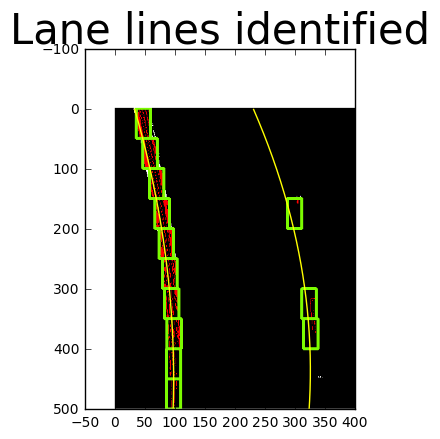

In [5]:
# Generate x and y values for plotting
ploty = np.linspace(0, filtered.shape[0]-1, filtered.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

base = np.copy(filtered)
base[base == 1] = 255
base = np.array(cv2.merge((base,base,base)),np.uint8)

def draw_centroid(filtered_image, new_image, centroid, window_width, window_height):
  width = int(window_width/2)
  height = int(window_height)
  top_left = (centroid[0] - width, centroid[1] - height)
  bottom_right = (centroid[0] + width, centroid[1])
  
  nonzero = filtered_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]].nonzero()
  
  for i in range(len(nonzero[0])):
    x = top_left[0] + nonzero[1][i]
    y = top_left[1] + nonzero[0][i]
    new_image[y][x] = [255, 0, 0]
    
  cv2.rectangle(new_image, top_left, bottom_right, (124,252,0), 3)
  return base

for centroid in window_centroids[0]:
  base = draw_centroid(filtered, base, centroid, window_width, window_height)
  
for centroid in window_centroids[1]:
  base = draw_centroid(filtered, base, centroid, window_width, window_height)
  
f, (ax1) = plt.subplots(1, 1, figsize=(10, 4))
f.tight_layout()
ax1.imshow(base)
ax1.set_title('Lane lines identified', fontsize=30)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
# plt.savefig('lane_lines_identified.png')


In [6]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = filtered.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, filtered.shape[0]-1, filtered.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

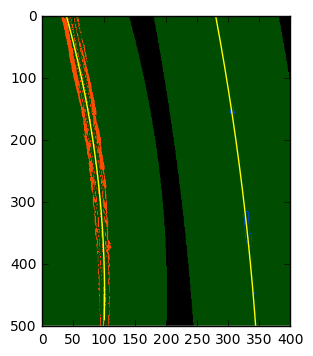

In [7]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((filtered, filtered, filtered))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 400)
plt.ylim(500, 0)
plt.show()
# plt.savefig('lane_lines_from_fit_line.png')

In [15]:
from lane_lines.find_lane_lines import find_lane_line

left_fit, right_fit = find_lane_line(filtered, None)


y_eval = np.max(filtered.shape[0] - 1)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, 'px', right_curverad, 'px')

ym_per_pix = 30/300 # meters per pixel in y dimension
xm_per_pix = 3.7/240 # meters per pixel in x dimension

ploty_left = np.linspace(0, len(leftx)-1, len(leftx) )
ploty_right = np.linspace(0, len(rightx)-1, len(rightx) )

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1641.19682102 px 4442.90269639 px
1063.07124059 m 2859.98979941 m


/Users/kyledorman/Documents/carnd/Advanced-Lane-Lines/lane_lines/find_lane_lines.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(image[image.shape[0]/2:,:], axis=0)


In [23]:
#Ay**2 +By+C

left_x_point = left_fit[0]*(filtered.shape[0]**2) + left_fit[1]*filtered.shape[0] + left_fit[2]
right_x_point = right_fit[0]*(filtered.shape[0]**2) + right_fit[1]*filtered.shape[0] + right_fit[2]

right_x_point - left_x_point

def derivative(fit):
  a = fit[0]
  b = fit[1]
  c = fit[2]

  pos = (-b + (b**2 - 4*a*c)**0.5) / (2 * a)
  neg = (-b - (b**2 - 4*a*c)**0.5) / (2 * a)
  return (pos, neg)

derivative(left_fit)

(-125.97532951295305, 1022.6202071801115)